<a href="https://colab.research.google.com/github/AayushGrover101/stock_prediction_algorithm/blob/master/Stock_Prediction_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
from pandas_datareader import data as pdr
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

import yfinance as yf

In [3]:
# load data
company = 'FB'

start = dt.datetime(2015,1,1)
end = dt.datetime(2021,1,1)

# take data from yahoo finance, start-end date using the "company" ticker symbol
yf.pdr_override()
data = pdr.get_data_yahoo(company, start, end)

[*********************100%***********************]  1 of 1 completed


In [4]:
# prepare data

# scale down values between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

# setup train data
for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [5]:
# develop the model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # prediction

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
46/46 [==============================] - 8s 13ms/step - loss: 0.0208
Epoch 2/25
46/46 [==============================] - 0s 11ms/step - loss: 0.0040
Epoch 3/25
46/46 [==============================] - 0s 11ms/step - loss: 0.0036
Epoch 4/25
46/46 [==============================] - 0s 10ms/step - loss: 0.0033
Epoch 5/25
46/46 [==============================] - 0s 11ms/step - loss: 0.0029
Epoch 6/25
46/46 [==============================] - 1s 11ms/step - loss: 0.0027
Epoch 7/25
46/46 [==============================] - 0s 10ms/step - loss: 0.0028
Epoch 8/25
46/46 [==============================] - 1s 11ms/step - loss: 0.0033
Epoch 9/25
46/46 [==============================] - 0s 11ms/step - loss: 0.0030
Epoch 10/25
46/46 [==============================] - 0s 11ms/step - loss: 0.0024
Epoch 11/25
46/46 [==============================] - 0s 11ms/step - loss: 0.0029
Epoch 12/25
46/46 [==============================] - 0s 11ms/step - loss: 0.0022
Epoch 13/25
46/46 [==================

In [6]:
# test model accuracy on past data
test_start = dt.datetime(2021,1,1)
test_end = dt.datetime.now()

test_data = pdr.get_data_yahoo(company, test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

[*********************100%***********************]  1 of 1 completed


In [7]:
# make predictions on test-data
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

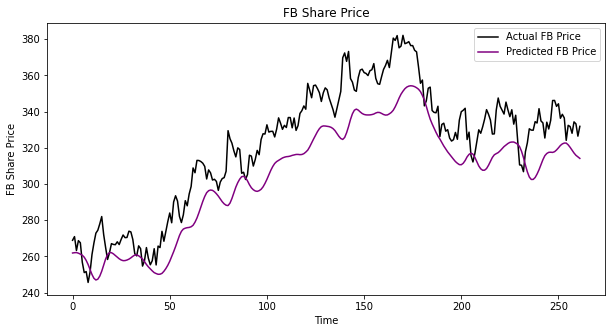

In [13]:
# plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(actual_prices, color="black", label=f"Actual {company.upper()} Price")
plt.plot(predicted_prices, color="purple", label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.show()

In [ ]:
# predict next day

real_data = [model_inputs[len(model_inputs) - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

Prediction: [[167.38013]]
